In [1]:
!pip install lightgbm

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install catboost

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
import catboost as cb
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Optional
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
import math 
import re 

import warnings
warnings.simplefilter("ignore")

In [4]:
train = pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/3/assignment_2_train.csv")
test = pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/3/assignment_2_test.csv")

In [5]:
y_train = train['isFraud'] 
y_test = test['isFraud'] 
x_train = train.drop('isFraud',axis=1)
x_test = test.drop('isFraud',axis=1)
cat_columns = list(x_test.select_dtypes(include=[np.object]))
for c in cat_columns:
    x_train[c] = x_train[c].fillna('missing').astype('category')
    x_test[c] = x_test[c].fillna('missing').astype('category')

### Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [6]:
x_valid, x_def = train_test_split(x_train, train_size=0.5, random_state=42)
y_valid, y_def = train_test_split(y_train, train_size=0.5, random_state=42)

In [7]:
params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 10,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}


In [8]:
cat_f = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9']
def cat_check(params = params):
    
    global x_train, y_train, x_valid, x_test, x_def, y_valid, y_test, y_def, cat_f
    cat_cat = cb.CatBoostClassifier(**params)
    cat_cat.fit(x_train, y_train,
               eval_set=[(x_train, y_train), (x_test, y_test)],
               cat_features = cat_f)

    train_score = roc_auc_score(y_train, cat_cat.predict_proba(x_train)[:,1])
    valid_score= roc_auc_score(y_valid, cat_cat.predict_proba(x_valid)[:,1])
    test_score= roc_auc_score(y_test, cat_cat.predict_proba(x_test)[:,1])
    def_score= roc_auc_score(y_def, cat_cat.predict_proba(x_def)[:,1])


    print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(test_score, 3)}, отложенная выборка--score: {round(def_score, 3)}, Test-score(LD): {round(valid_score, 3)}")
    return cat_cat

### Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [9]:
def datamaker(df):
    df['TransactionDT'] = pd.to_datetime(df['TransactionDT'], unit ='s',origin='2017-12-01') 
    df['TransactionDT_year'] = df['TransactionDT'].dt.year
    df['TransactionDT_month'] = df['TransactionDT'].dt.month
    df['TransactionDT_weekday'] = df['TransactionDT'].dt.weekday
    df['TransactionDT_year_hour'] = df['TransactionDT'].dt.hour
    df['TransactionDT_year_day'] = df['TransactionDT'].dt.day

In [10]:
datamaker(x_train)
datamaker(x_valid)
datamaker(x_test)
datamaker(x_def)

### Задание 2: сделать конкатенацию признаков
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2
Рассматривать их как категориальных признаки.

In [11]:
def featmaker(df):
    df['card1-2'] = df['card1'].fillna('').astype('string')+ df['card2'].fillna('').astype('string')
    df['card1-5'] = df['card1-2'] +df['card3'].fillna('').astype('string')+ df['card5'].fillna('').astype('string')
    df['card1-card5_addr1-2']= df['card1-5'].fillna('').astype('string') + df['addr1'].fillna('').astype('string') + df['addr2'].fillna('').astype('string')
    df['card1-2']=df['card1-2'].astype('category')
    df['card1-5'] = df['card1-5'].astype('category')
    df['card1-card5_addr1-2'] = df['card1-card5_addr1-2'].astype('category')

In [12]:
featmaker(x_train)
featmaker(x_valid)
featmaker(x_test)
featmaker(x_def)

In [13]:
cat_f.append('card1-2')
cat_f.append('card1-5')
cat_f.append('card1-card5_addr1-2')

###  Задание 3: Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.

In [14]:
def freq_en(df, feature_list = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']):
    for feature in feature_list:
        freq_encoder = df[feature].value_counts(normalize=True)
        df[feature+"_freq_enc"] = df[feature].map(freq_encoder).astype('float64')

In [15]:
freq_en(x_train)
freq_en(x_valid)
freq_en(x_test)
freq_en(x_def)

### Задание 4: Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [16]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = "_groupby_"+groupby_id

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".lower() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [17]:
def create_stats_feature(df, stats, groupby_id):
    df = df.merge(
        stats, how="left", on=groupby_id, suffixes=''
    )
    df["transactionamt_stats_groupby_"+groupby_id ] = df["transactionamt_mean_groupby_"+groupby_id] / df["transactionamt_std_groupby_"+groupby_id]
    df.drop(["transactionamt_mean_groupby_"+groupby_id, "transactionamt_std_groupby_"+groupby_id],axis=1)
    return df

In [18]:
groupby_id_list = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'card1-2','card1-5','card1-card5_addr1-2']
aggs = {
    "TransactionAmt": [np.mean, np.std],
}

for groupby_id in groupby_id_list:
    stats = create_numerical_aggs(
        x_train, groupby_id=groupby_id, aggs=aggs
    )
    x_train = create_stats_feature(x_train, stats, groupby_id)
    x_valid = create_stats_feature(x_valid, stats, groupby_id)
    x_test = create_stats_feature(x_test, stats, groupby_id)
    x_def = create_stats_feature(x_def, stats, groupby_id)
    

### Задание 5: Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [19]:
aggs = {
    "D15": [np.mean, np.std],
}

for groupby_id in groupby_id_list:
    stats = create_numerical_aggs(
        x_train, groupby_id=groupby_id, aggs=aggs
    )
    x_train = create_stats_feature(x_train, stats, groupby_id)
    x_valid = create_stats_feature(x_valid, stats, groupby_id)
    x_test = create_stats_feature(x_test, stats, groupby_id)
    x_def = create_stats_feature(x_def, stats, groupby_id)

### Задание 6: выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельных признак - логарифм от TransactionAmt

In [20]:
def delflo(df):
    df[['TransactionAmt_f', 'TransactionAmt_int']] = df['TransactionAmt'].apply(lambda x: math.modf(x)).apply(pd.Series)


In [21]:
delflo(x_train)
delflo(x_valid)
delflo(x_test)
delflo(x_def)

### Задание 7 (опция): выполнить предварительную подготовку / очистку признаков P_emaildomain и R_emaildomain (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.

In [22]:
def email_cl(df):
    df.loc[df['P_emaildomain']=='gmail', 'P_emaildomain'] = 'gmail.com'
    df['P_emaildomain'] = df['P_emaildomain'].str.replace(r'.mx$','')
    df.loc[df['R_emaildomain']=='gmail', 'R_emaildomain'] = 'gmail.com'
    df['R_emaildomain'] = df['R_emaildomain'].str.replace(r'.mx$','')    

In [23]:
x_train['P_emaildomain'].value_counts()

gmail.com           67198
yahoo.com           28992
missing             28440
hotmail.com         15058
anonymous.com       13328
aol.com              8583
comcast.net          2916
icloud.com           1677
outlook.com          1484
msn.com              1423
att.net              1223
sbcglobal.net        1092
verizon.net           971
live.com              894
bellsouth.net         713
ymail.com             654
me.com                624
cox.net               570
yahoo.com.mx          522
charter.net           372
optonline.net         362
live.com.mx           254
mac.com               214
rocketmail.com        201
earthlink.net         173
mail.com              147
outlook.es            142
roadrunner.com        119
gmail                 115
juno.com              111
embarqmail.com        109
windstream.net         95
twc.com                86
hotmail.es             85
frontier.com           79
q.com                  68
hotmail.fr             68
netzero.com            65
web.de      

In [24]:
x_train['R_emaildomain'].value_counts()

missing           119700
gmail.com          24644
hotmail.com        10129
anonymous.com       9882
yahoo.com           5666
                   ...  
netzero.net            7
scranton.edu           6
sc.rr.com              6
protonmail.com         5
hotmail.de             4
Name: R_emaildomain, Length: 61, dtype: int64

In [25]:
email_cl(x_train)
mask = x_train['P_emaildomain'].value_counts()
x_train.loc[x_train['P_emaildomain'].isin(mask.index[mask<500]), 'P_emaildomain'] = 'other'
mask = x_train.value_counts()

In [26]:
email_cl(x_valid)
email_cl(x_test)
email_cl(x_def)
x_valid.loc[x_valid['P_emaildomain'].isin(mask.index), 'P_emaildomain'] = 'other'
x_test.loc[x_test['P_emaildomain'].isin(mask.index), 'P_emaildomain'] = 'other'
x_def.loc[x_def['P_emaildomain'].isin(mask.index), 'P_emaildomain'] = 'other'

In [27]:
mask = x_train['R_emaildomain'].value_counts()
x_train.loc[x_train['R_emaildomain'].isin(mask.index[mask<200]), 'R_emaildomain'] = 'other'
mask = x_train.value_counts()

In [28]:
x_valid.loc[x_valid['R_emaildomain'].isin(mask.index), 'R_emaildomain'] = 'other'
x_test.loc[x_test['R_emaildomain'].isin(mask.index), 'R_emaildomain'] = 'other'
x_def.loc[x_def['R_emaildomain'].isin(mask.index), 'R_emaildomain'] = 'other'

In [29]:
freq_en(x_train, ['P_emaildomain', 'R_emaildomain'])
freq_en(x_valid, ['P_emaildomain', 'R_emaildomain'])
freq_en(x_test, ['P_emaildomain', 'R_emaildomain'])
freq_en(x_def, ['P_emaildomain', 'R_emaildomain'])

In [30]:
cat_cat = cat_check()

0:	test: 0.6042292	test1: 0.5835460	best: 0.5835460 (0)	total: 1.03s	remaining: 17m 9s
50:	test: 0.8814805	test1: 0.8388766	best: 0.8388766 (50)	total: 37.4s	remaining: 11m 35s
100:	test: 0.9539647	test1: 0.8480437	best: 0.8480437 (100)	total: 1m 16s	remaining: 11m 17s
150:	test: 0.9621013	test1: 0.8515424	best: 0.8515424 (150)	total: 1m 55s	remaining: 10m 51s
200:	test: 0.9685384	test1: 0.8585655	best: 0.8585655 (200)	total: 2m 35s	remaining: 10m 16s
250:	test: 0.9738787	test1: 0.8622738	best: 0.8624910 (248)	total: 3m 16s	remaining: 9m 46s
300:	test: 0.9764178	test1: 0.8643904	best: 0.8645983 (299)	total: 3m 55s	remaining: 9m 7s
350:	test: 0.9782101	test1: 0.8658906	best: 0.8658906 (350)	total: 4m 34s	remaining: 8m 28s
400:	test: 0.9794870	test1: 0.8671278	best: 0.8671278 (400)	total: 5m 13s	remaining: 7m 48s
450:	test: 0.9808020	test1: 0.8691629	best: 0.8691629 (450)	total: 5m 51s	remaining: 7m 8s
500:	test: 0.9809796	test1: 0.8693864	best: 0.8693910 (484)	total: 6m 28s	remaining: 6

### Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [103]:
f_imp = pd.DataFrame(zip(x_train.columns, cat_cat.feature_importances_), columns=['feature_name', 'importance']).sort_values(by='importance')

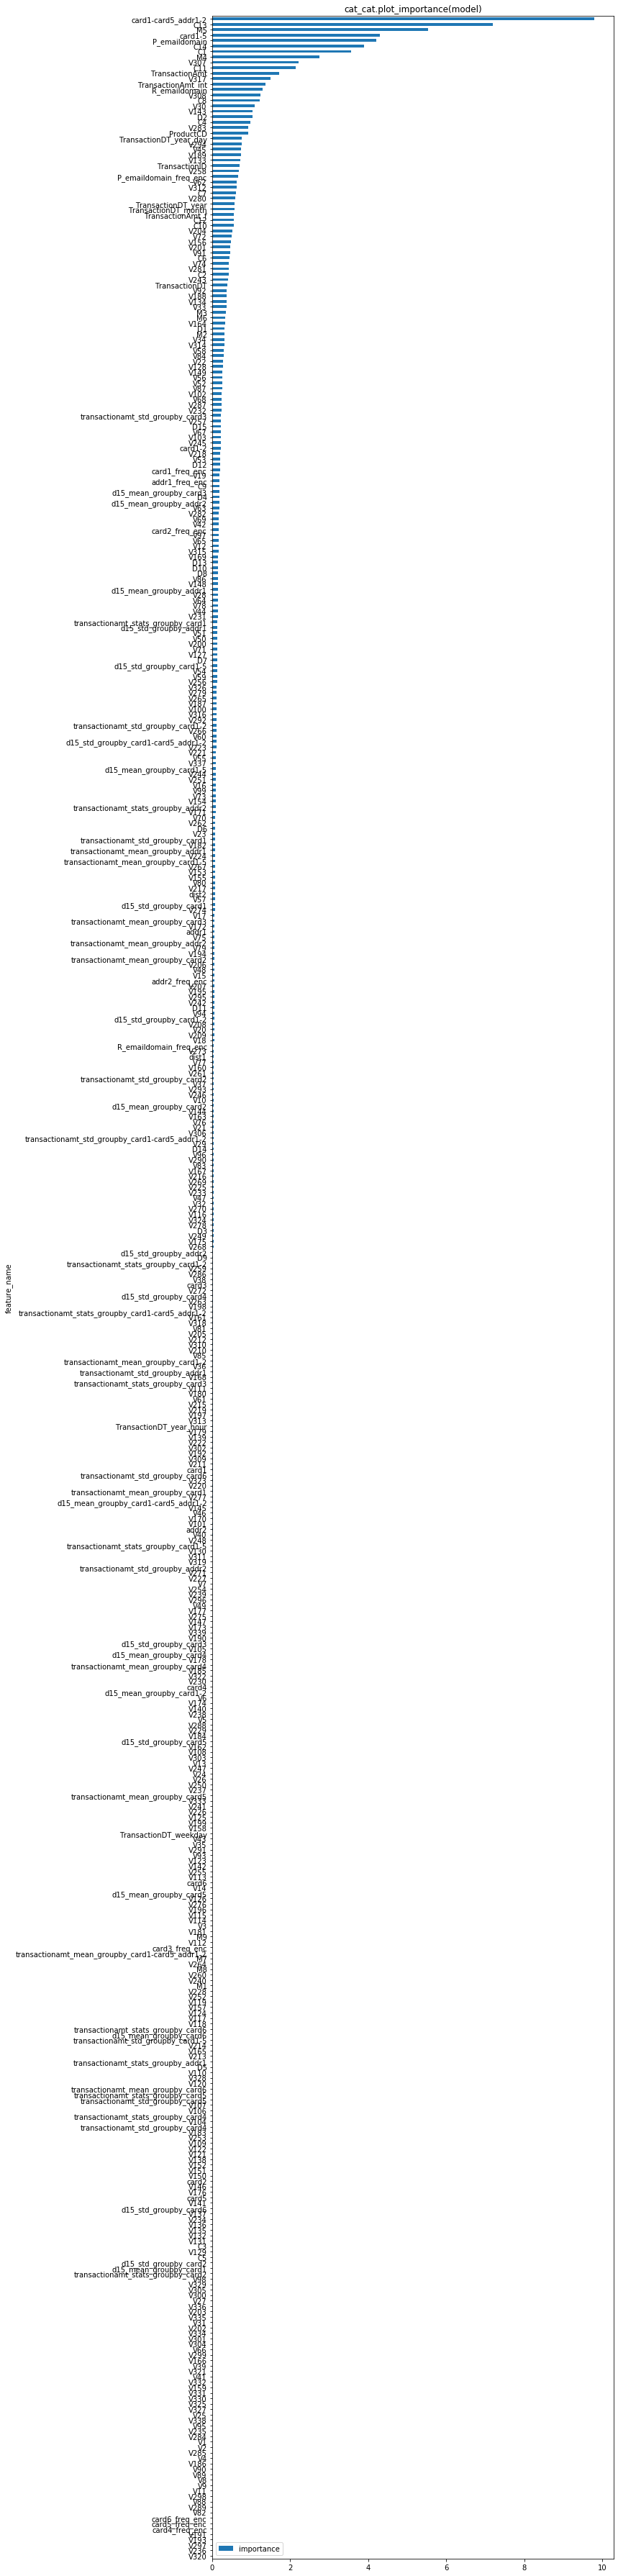

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(10, 65))
f_imp.plot.barh(x='feature_name', y='importance',ax=ax)
plt.title("cat_cat.plot_importance(model)")
plt.show()

### Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [46]:
x_train_copy, x_valid_copy, x_test_copy, x_def_copy  = x_train, x_valid, x_test, x_def

In [35]:
feature_name_imp = f_imp.loc[f_imp['importance']>1,'feature_name']
feature_name_imp

17                         C2
98                        V45
370                      V317
394       TransactionDT_month
397    TransactionDT_year_day
347                      V294
19                         C4
26                        C11
465        TransactionAmt_int
360                      V307
361                      V308
3                   ProductCD
2              TransactionAmt
14              P_emaildomain
15              R_emaildomain
16                         C1
29                        C14
399                   card1-5
49                         M5
28                        C13
400       card1-card5_addr1-2
Name: feature_name, dtype: object

In [36]:
cat_f = ['ProductCD','card1-5','card1-card5_addr1-2','P_emaildomain', 'R_emaildomain','M5']
x_train, x_valid, x_test, x_def  = x_train[feature_name_imp], x_valid[feature_name_imp], x_test[feature_name_imp], x_def[feature_name_imp]

In [37]:
x_train.info()
cat_columns = list(x_test.select_dtypes(include=[np.object]))
for c in cat_columns:
    x_train[c] = x_train[c].astype('category')
    x_test[c] = x_test[c].astype('category')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180000 entries, 0 to 179999
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   C2                      180000 non-null  float64 
 1   V45                     106921 non-null  float64 
 2   V317                    179989 non-null  float64 
 3   TransactionDT_month     180000 non-null  int64   
 4   TransactionDT_year_day  180000 non-null  int64   
 5   V294                    179989 non-null  float64 
 6   C4                      180000 non-null  float64 
 7   C11                     180000 non-null  float64 
 8   TransactionAmt_int      180000 non-null  float64 
 9   V307                    179989 non-null  float64 
 10  V308                    179989 non-null  float64 
 11  ProductCD               180000 non-null  category
 12  TransactionAmt          180000 non-null  float64 
 13  P_emaildomain           180000 non-null  category
 14  R_em

In [38]:
cat_cat = cat_check()

0:	test: 0.7475177	test1: 0.7164893	best: 0.7164893 (0)	total: 339ms	remaining: 5m 38s
50:	test: 0.9172515	test1: 0.8449683	best: 0.8469449 (41)	total: 14.5s	remaining: 4m 29s
100:	test: 0.9680143	test1: 0.8432241	best: 0.8469449 (41)	total: 24.3s	remaining: 3m 36s
150:	test: 0.9737232	test1: 0.8483952	best: 0.8484903 (149)	total: 38s	remaining: 3m 33s
200:	test: 0.9767503	test1: 0.8545546	best: 0.8545546 (200)	total: 52.6s	remaining: 3m 29s
250:	test: 0.9787182	test1: 0.8575237	best: 0.8575770 (247)	total: 1m 7s	remaining: 3m 21s
300:	test: 0.9803010	test1: 0.8595088	best: 0.8595193 (297)	total: 1m 22s	remaining: 3m 11s
350:	test: 0.9815845	test1: 0.8599473	best: 0.8599522 (344)	total: 1m 37s	remaining: 3m
400:	test: 0.9822120	test1: 0.8606856	best: 0.8606856 (400)	total: 1m 52s	remaining: 2m 48s
450:	test: 0.9829896	test1: 0.8618889	best: 0.8619121 (447)	total: 2m 8s	remaining: 2m 36s
500:	test: 0.9836028	test1: 0.8619124	best: 0.8622132 (468)	total: 2m 23s	remaining: 2m 22s
550:	tes

### Задание 3: использовать permutation importance, выполнить задание 1 и 2.

In [47]:
x_train, x_valid, x_test, x_def  =  x_train_copy, x_valid_copy, x_test_copy, x_def_copy 
cat_f =  ['ProductCD','card4','card6','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9','card1-2', 'card1-5', 'card1-card5_addr1-2']

In [40]:
params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 10,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}
cat_cat = cb.CatBoostClassifier(**params)
cat_cat.fit(x_train, y_train,
               eval_set=[(x_train, y_train), (x_test, y_test)],
               cat_features = cat_f)

0:	test: 0.6830701	test1: 0.6727212	best: 0.6727212 (0)	total: 769ms	remaining: 12m 48s
50:	test: 0.8915592	test1: 0.8370653	best: 0.8370653 (50)	total: 34.4s	remaining: 10m 39s
100:	test: 0.9561195	test1: 0.8436125	best: 0.8447788 (63)	total: 1m 9s	remaining: 10m 22s
150:	test: 0.9655659	test1: 0.8459646	best: 0.8459646 (150)	total: 1m 46s	remaining: 10m 1s
200:	test: 0.9698029	test1: 0.8558110	best: 0.8558110 (200)	total: 2m 23s	remaining: 9m 29s
250:	test: 0.9734532	test1: 0.8603120	best: 0.8603120 (250)	total: 2m 59s	remaining: 8m 56s
300:	test: 0.9758607	test1: 0.8634738	best: 0.8634740 (299)	total: 3m 36s	remaining: 8m 22s
350:	test: 0.9773629	test1: 0.8660134	best: 0.8660339 (349)	total: 4m 12s	remaining: 7m 46s
400:	test: 0.9786354	test1: 0.8668022	best: 0.8670052 (392)	total: 4m 48s	remaining: 7m 10s
450:	test: 0.9798653	test1: 0.8678367	best: 0.8678367 (450)	total: 5m 23s	remaining: 6m 33s
500:	test: 0.9804184	test1: 0.8684359	best: 0.8684426 (499)	total: 5m 58s	remaining: 5m

In [41]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(
    cat_cat, x_valid, y_valid, scoring="roc_auc", n_jobs=-1, random_state=42
)

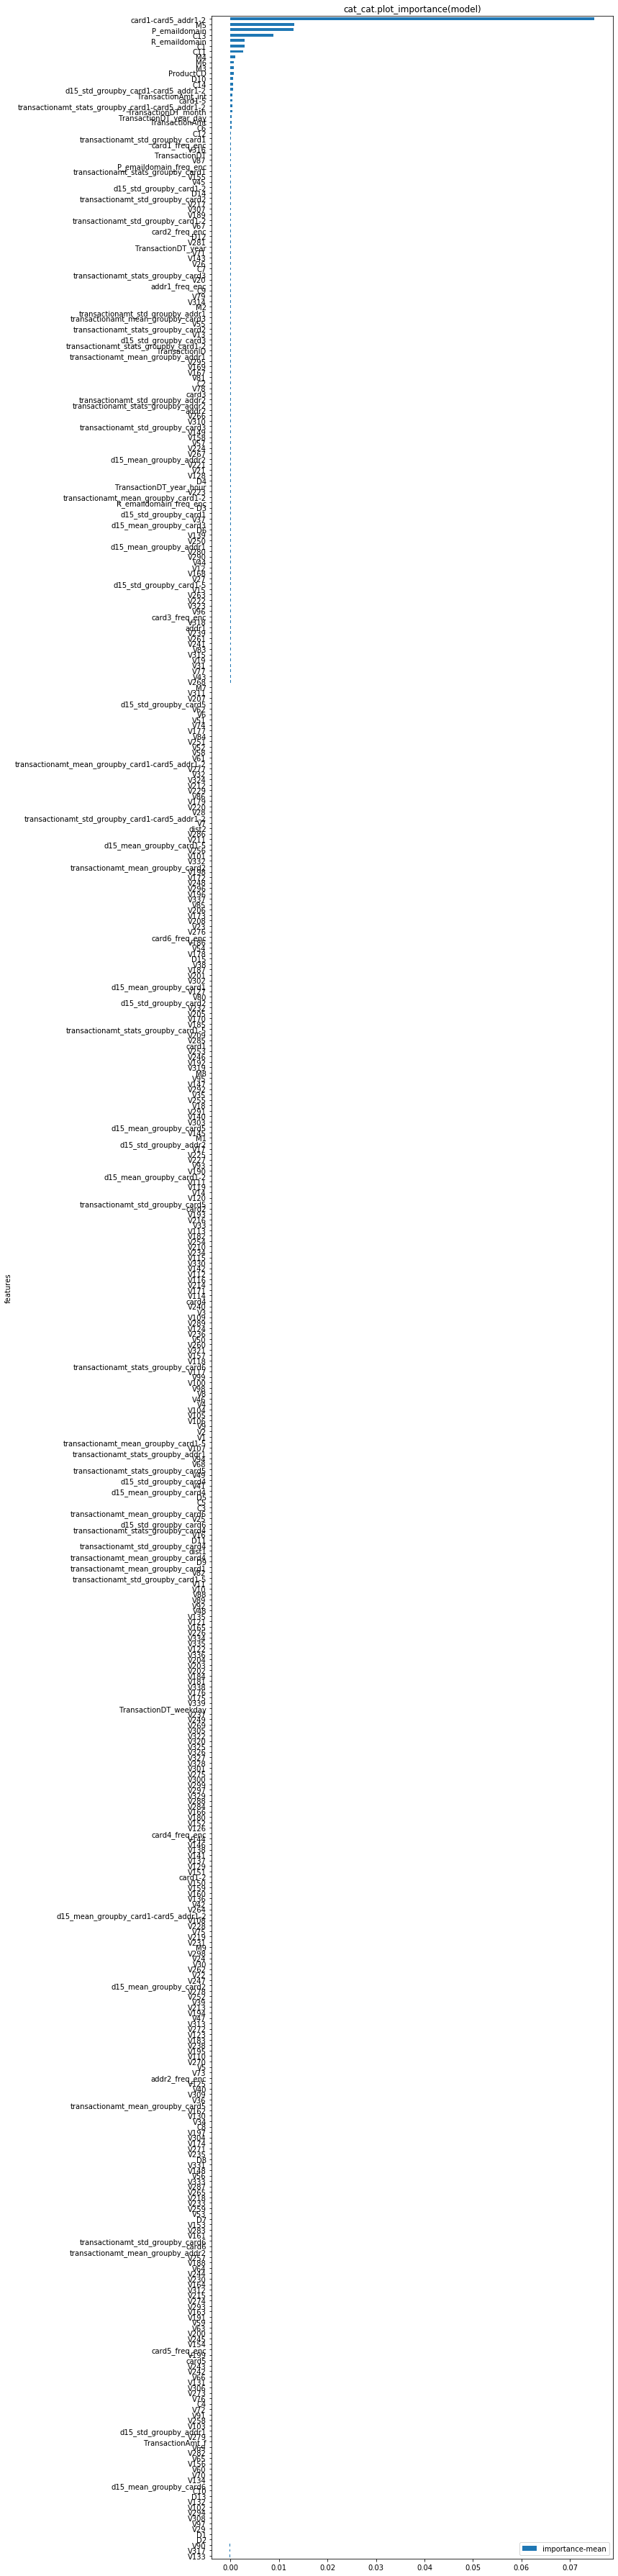

In [42]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=True
)
importance_scores = importance_scores.reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 65))
importance_scores.plot.barh(x='features', y='importance-mean',ax=ax)
plt.title("cat_cat.plot_importance(model)")
plt.show()

In [43]:
feature_name_imp = importance_scores.loc[importance_scores['importance-mean']>0.001,'features']
feature_name_imp

461                    C11
462                     C1
463          R_emaildomain
464                    C13
465          P_emaildomain
466                     M5
467    card1-card5_addr1-2
Name: features, dtype: object

In [44]:
x_train_copy, x_valid_copy, x_test_copy, x_def_copy  = x_train, x_valid, x_test, x_def

In [45]:
cat_f = ['card1-card5_addr1-2','P_emaildomain', 'R_emaildomain','M5']
x_train, x_valid, x_test, x_def  = x_train[feature_name_imp], x_valid[feature_name_imp], x_test[feature_name_imp], x_def[feature_name_imp]

In [46]:
cat_cat = cat_check()

0:	test: 0.6842933	test1: 0.6938694	best: 0.6938694 (0)	total: 195ms	remaining: 3m 14s
50:	test: 0.9514692	test1: 0.8003764	best: 0.8031831 (41)	total: 8.09s	remaining: 2m 30s
100:	test: 0.9722226	test1: 0.7937883	best: 0.8031831 (41)	total: 14.2s	remaining: 2m 6s
150:	test: 0.9763527	test1: 0.8119765	best: 0.8119765 (150)	total: 22.6s	remaining: 2m 6s
200:	test: 0.9796238	test1: 0.8213838	best: 0.8213838 (200)	total: 32.2s	remaining: 2m 7s
250:	test: 0.9823340	test1: 0.8270429	best: 0.8270824 (248)	total: 40.2s	remaining: 1m 59s
300:	test: 0.9834630	test1: 0.8299104	best: 0.8300293 (295)	total: 48.9s	remaining: 1m 53s
350:	test: 0.9843950	test1: 0.8316285	best: 0.8316285 (350)	total: 57.2s	remaining: 1m 45s
400:	test: 0.9849698	test1: 0.8326919	best: 0.8326919 (400)	total: 1m 5s	remaining: 1m 37s
450:	test: 0.9853938	test1: 0.8337597	best: 0.8337780 (449)	total: 1m 12s	remaining: 1m 28s
500:	test: 0.9854863	test1: 0.8338844	best: 0.8339279 (498)	total: 1m 19s	remaining: 1m 19s
550:	te

### Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше  усмотрение), переобучить модель и оценить изменение качества.

In [48]:
x_train, x_valid, x_test, x_def  =  x_train_copy, x_valid_copy, x_test_copy, x_def_copy 

In [73]:
x_train = x_train.drop('card1-card5_addr1-2', axis=1)
x_train = x_train.drop('card1-2', axis=1)
x_train = x_train.drop('card1-5', axis=1)

In [54]:
x_train.TransactionDT = pd.to_numeric((pd.to_datetime(x_train.TransactionDT) - pd.to_datetime(np.datetime64('2017-12-01'))))/100000000

In [65]:

x_train[['P_emaildomain', 'R_emaildomain'] = x_train.dtypes[x_train.dtypes=="object"].astype("category")

In [76]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()
    categorical = X.dtypes[X.dtypes=="category"].index.tolist()
    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X
x_train =prepare_data( x_train)

In [78]:
dtrain = xgb.DMatrix(x_train, label=y_train)

XGBoostError: [18:20:43] C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/data/data.cc:945: Check failed: valid: Input data contains `inf` or `nan`

In [56]:
dtrain, dvalid, dtest, ddef = xgb.DMatrix(x_train, label=y_train, enable_categorical=True), xgb.DMatrix(x_valid, label=y_valid, enable_categorical=True), xgb.DMatrix(x_test, label=y_test, enable_categorical=True), xgb.DMatrix(x_def, label=y_def, enable_categorical=True)


ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.TransactionDT, ProductCD, card4, card6, P_emaildomain, R_emaildomain, M1, M2, M3, M4, M5, M6, M7, M8, M9, TransactionDT_year, card1-2, card1-5, card1-card5_addr1-2

In [57]:
!pip install boostaroota

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [53]:
from boostaroota import BoostARoota
br = BoostARoota(metric='auc')
br.fit(x_train, y_train)
x_train_br = br.transform(x_train)
x_valid_br = br.transform(x_valid)
x_test_br = br.transform(x_test)
x_def_br = br.transform(x_def)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.TransactionDT, ProductCD, card4, card6, P_emaildomain, R_emaildomain, M1, M2, M3, M4, M5, M6, M7, M8, M9, TransactionDT_year, card1-2, card1-5, card1-card5_addr1-2, ShadowVar2, ShadowVar4, ShadowVar8, ShadowVar10, ShadowVar15, ShadowVar16, ShadowVar46, ShadowVar47, ShadowVar48, ShadowVar49, ShadowVar50, ShadowVar51, ShadowVar52, ShadowVar53, ShadowVar54, ShadowVar394, ShadowVar399, ShadowVar400, ShadowVar401

In [ ]:
cat_cat = cb.CatBoostClassifier(**params)
cat_cat_br.fit(x_train_br, y_train,
               eval_set=[(x_train, y_train), (x_test_br, y_test_br)],
               cat_features = cat_f)

    train_score = roc_auc_score(y_train, cat_cat.predict_proba(x_train)[:,1])
    valid_score= roc_auc_score(y_valid, cat_cat.predict_proba(x_valid)[:,1])
    test_score= roc_auc_score(y_test, cat_cat.predict_proba(x_test)[:,1])
    def_score= roc_auc_score(y_def, cat_cat.predict_proba(x_def)[:,1])


    print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(test_score, 3)}, отложенная выборка--score: {round(def_score, 3)}, Test-score(LD): {round(valid_score, 3)}")


### Задание 5: использовать shap, выполнить задание 1 и 2.

In [33]:
!pip install shap

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [34]:
import shap

In [38]:
from catboost import *

In [40]:
cat_f

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'card1-2',
 'card1-5',
 'card1-card5_addr1-2']

In [61]:
x_train[list(x_train.select_dtypes(include=[np.object]))] = x_train[list(x_train.select_dtypes(include=[np.object]))].astype("category")
x_test[list(x_test.select_dtypes(include=[np.object]))] = x_test[list(x_test.select_dtypes(include=[np.object]))].astype("category")

In [55]:
x_valid[list(x_valid.select_dtypes(include=[np.object]))] = x_valid[list(x_valid.select_dtypes(include=[np.object]))].astype("category")

In [62]:
params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 10,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}
cat_cat = cb.CatBoostClassifier(**params)
cat_cat.fit(x_train, y_train,
               eval_set=[(x_train, y_train), (x_test, y_test)],
               cat_features = cat_f)

0:	test: 0.6042292	test1: 0.5835460	best: 0.5835460 (0)	total: 815ms	remaining: 13m 33s
50:	test: 0.8814805	test1: 0.8388766	best: 0.8388766 (50)	total: 36.3s	remaining: 11m 15s
100:	test: 0.9539647	test1: 0.8480437	best: 0.8480437 (100)	total: 1m 14s	remaining: 10m 59s
150:	test: 0.9621013	test1: 0.8515424	best: 0.8515424 (150)	total: 1m 52s	remaining: 10m 31s
200:	test: 0.9685384	test1: 0.8585655	best: 0.8585655 (200)	total: 2m 30s	remaining: 9m 58s
250:	test: 0.9738787	test1: 0.8622738	best: 0.8624910 (248)	total: 3m 9s	remaining: 9m 26s
300:	test: 0.9764178	test1: 0.8643904	best: 0.8645983 (299)	total: 3m 49s	remaining: 8m 52s
350:	test: 0.9782101	test1: 0.8658906	best: 0.8658906 (350)	total: 4m 28s	remaining: 8m 15s
400:	test: 0.9794870	test1: 0.8671278	best: 0.8671278 (400)	total: 5m 6s	remaining: 7m 38s
450:	test: 0.9808020	test1: 0.8691629	best: 0.8691629 (450)	total: 5m 45s	remaining: 7m
500:	test: 0.9809796	test1: 0.8693864	best: 0.8693910 (484)	total: 6m 23s	remaining: 6m 21

In [58]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180000 entries, 0 to 179999
Columns: 468 entries, TransactionID to R_emaildomain_freq_enc
dtypes: category(15), datetime64[ns](1), float64(443), int64(7), object(2)
memory usage: 628.8+ MB


In [59]:
x_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 89999
Columns: 468 entries, TransactionID to R_emaildomain_freq_enc
dtypes: category(17), datetime64[ns](1), float64(443), int64(7)
memory usage: 313.6 MB


In [65]:
shap_values = cat_cat.get_feature_importance(Pool(x_valid, y_valid, cat_features = cat_f), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

### Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

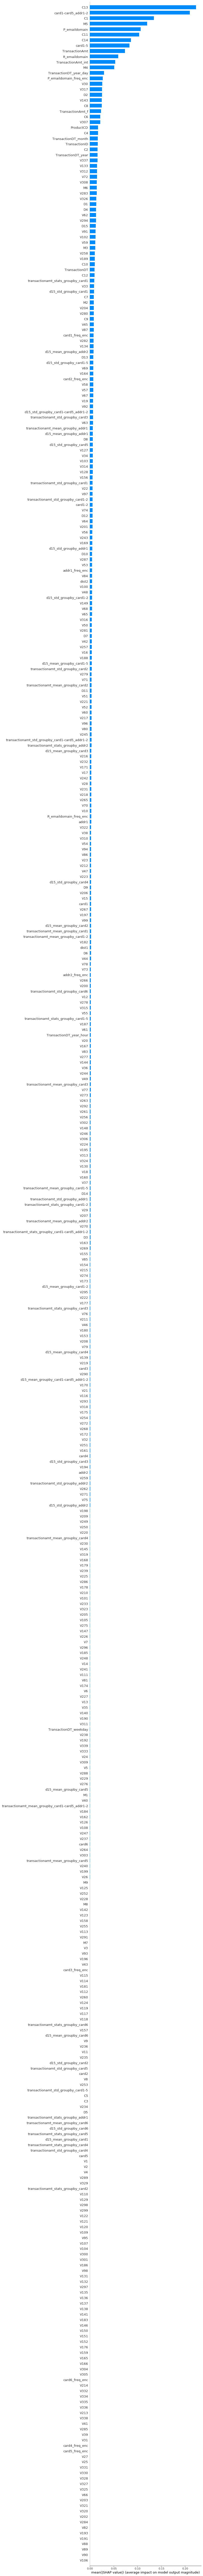

In [72]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

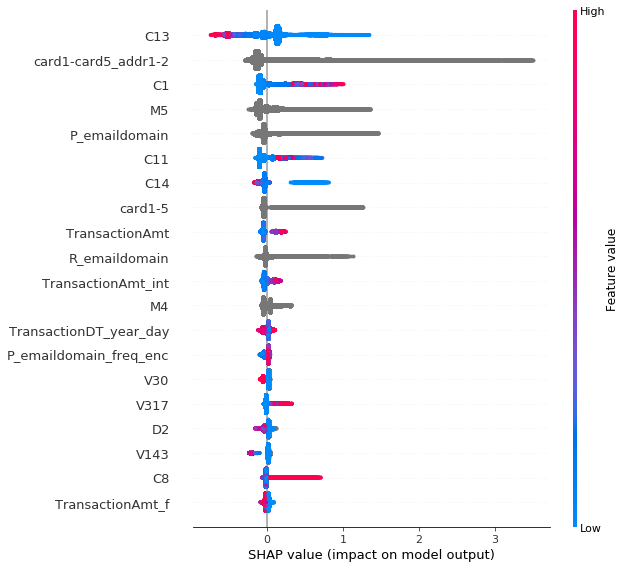

In [73]:
shap.summary_plot(shap_values, x_valid)

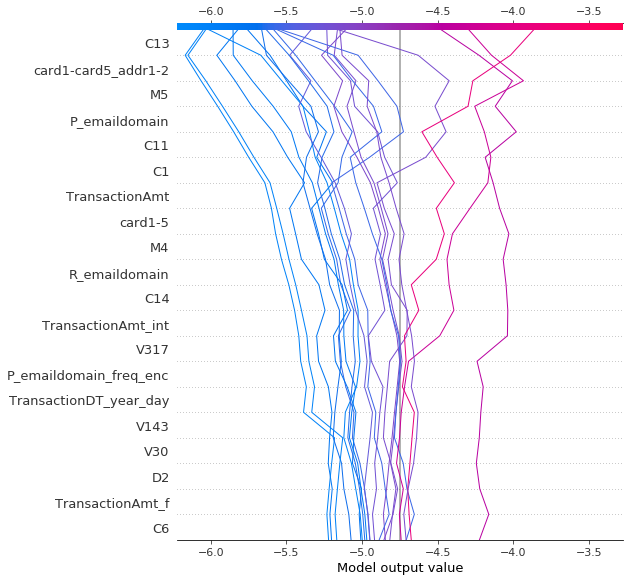

In [75]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20]
)